# Exercise 1 - Skin lesion segmentation /65 pts
In this first exercise we will built a segmentation model for skin lesions. In this first part of the coursework we will investigate the effect of augmentation and pseudolabeling on the performance of a segmentation model applied to skin lesion segmentation. In addition to adequate programming, marks will be attributed to your commenting. We provide this skeleton notebook to help with the task. You will need to add / split cells as you see fit to address the questions. While we will detail the different steps in greater details in the first part of the exercise, you will be given less step by step instructions as the exercise progresses

The data for this exercise is available [here](https://liveuclac.sharepoint.com/:f:/s/MPHY0050/ElG_LwAkhyxKj_CwV7b6laMBznYYy8IPuy0RdCyVkU6E8g?e=pcR3kf)


In [1]:
import glob
from skimage import io, transform
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import sys
import random
import torch.optim as optim
from torch.autograd import Variable
import os
import time
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import Compose
from torchvision.transforms import RandomCrop
import re
from scipy.ndimage import label
from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from torch.utils.data import Dataset, DataLoader
from scipy.ndimage import affine_transform
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from PIL import Image
from torchvision.transforms.functional import InterpolationMode
import affine
from affine import Affine
import scipy as sp
import torchinfo
from torchinfo import summary

## Exercise 1 - Part 1 - Data loading /5pts
The first stage will be to build a dataset and associated dataloader and visualise the first batch of images and labels - Fill in the missing parts in the below cell that defines where to look for your data

In [3]:

def sorted_aphanumeric(data):
    # Function sorting the data by alphabetical order
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(data, key=alphanum_key)

def getiosubjects(path_dir_image, path_dir_target):
    # Function finding the appropriate pairs of image and label images
    # I have replaced the end of the image string with "_Segmentation.png' to select the correct
    # segmentation file
    subjects_list = sorted_aphanumeric(os.listdir(path_dir_image))
    iosubjects = []
    for pics in subjects_list:
        subject = {'image': path_dir_image + pics , 'label': path_dir_target + pics.replace('.jpg', '_Segmentation.png') }
        iosubjects.append(subject)

    return iosubjects

class ISICDataset(Dataset):
    """Skin lesion dataset."""

    def __init__(self, image_path, label_path, transform=None):

        self.image_path = image_path
        self.label_path = label_path
        self.transform = transform
        self.pairs = getiosubjects(self.image_path, self.label_path)


    def __len__(self):
        return len(glob.glob(self.image_path+'*'))

    def __getitem__(self, idx):   
        if torch.is_tensor(idx):
            idx = idx.tolist()   
        
        image_loc, label_loc = self.pairs[idx]['image'], self.pairs[idx]['label']
        image_pixels = (np.array(Image.open(image_loc)))
        pixels_float = image_pixels.astype('float32')  # convert from integers to floats
        image = image_pixels/255.0  # normalize pixel values to the range 0-1 (learning affected by large values)
        label = np.array(Image.open(label_loc))


        sample = {'image': image, 'label': label}   # dictionary of sample path names - images 
                                                    # and labels are linked
        if self.transform:
            sample = self.transform(sample)

        return sample

In [4]:
def visualise_samples(sample):
    numb_images = sample['image'].shape[0]
    fig, ax = plt.subplots(2, numb_images)
    for k in range(numb_images):
        ax[0,k].imshow(np.transpose(sample['image'][k,...],(1,2,0)))
        ax[1,k].imshow(np.squeeze(sample['label'][k,...]),cmap='Greys')
        ax[0,k].set_xticks([])
        ax[1,k].set_xticks([])
        ax[0,k].set_yticks([])
        ax[1,k].set_yticks([])
    plt.show()

In [31]:
# You will need the following classes at some point...
class CenterCrop(object):
    """Crop and pad the image in a sample to a given size.

    Args:
        output_size (tuple): Desired output size. 
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        new_h = self.output_size[0]
        new_w = self.output_size[1]
        img = transforms.functional.center_crop(image, [new_h, new_w])
        lab = transforms.functional.center_crop(label, [new_h, new_w])

        return {'image': img, 'label': lab}

class Rescale(object):
    """Rescale the image in a sample to a given size.

    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        new_h = self.output_size[0]
        new_w = self.output_size[1]

        img = transforms.functional.resize(image, [new_h, new_w])

        lab = transforms.functional.resize(label, [new_h, new_w], InterpolationMode.NEAREST)

        return {'image': img, 'label': lab}
    


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        label = np.expand_dims(label,0)
        return {'image': torch.from_numpy(image).float(),
                'label': torch.from_numpy(label).long()}

Define a transform object so that all the images to be fed to the network are first cropped to a square of 1000 by 1000 and then resized to 256 x 256 and create a dataset using that transform object

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


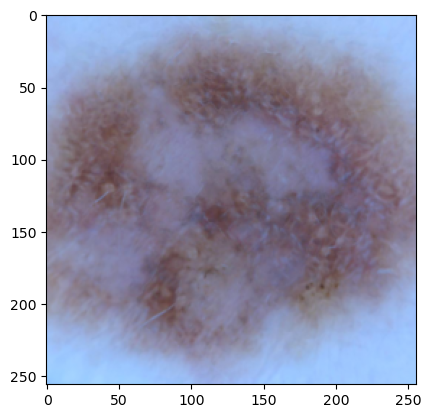

In [32]:
transforms_object_simple = transforms.Compose([ToTensor(), CenterCrop((1000, 1000)), Rescale((256, 256))])

dataset = ISICDataset('Labelled\Images\\', 'Labelled\Labels\\', transform = transforms_object_simple)
num_samples = dataset.__len__()
sample = dataset.__getitem__(24)



# x = x.to(memory_format=torch.channels_last)

plt.imshow(np.transpose(sample['image'], (1, 2, 0)))

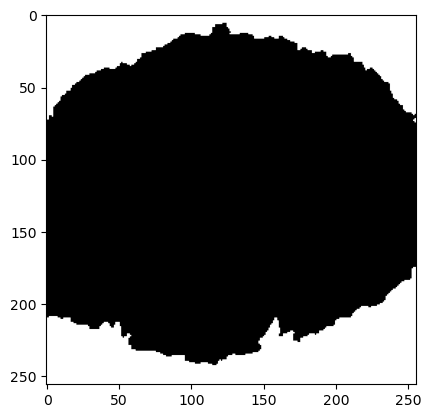

In [33]:
plt.imshow(np.transpose(sample['label'], (1, 2, 0)), cmap = 'Greys')

Create a dataloader with batch size 4 and visualise the images and labels of the first sample

In [68]:
num_cores = os.cpu_count()
BATCH_SIZE = 4
dataloader = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle = True)

## Exercise 1 - Part 2 - Augmentation implementation /20pts

Now it is time to implement some possible augmentations and visualise the effect
Following the above example of transforms, implement
- Random Gamma / 2pts
- Random axis flip (along x or y direction ) / 3pts
- Random affine (including rotation, shear, zoom, translation) with distinct probability for each component and with respect to the center of the image / 10pts

Each of these should take as argument a probability or list of probability values for occurring.
Do visualise the effect of each of the transformations and each component of the affine transformation / 5pts

[affine](https://pypi.org/project/affine/) is one of the packages you can use to create affine transformations

In [37]:
class RandomGamma(object):
    """Randomly apply gamma transform to image.

    Args:
        probability, gamma_min, gamma_max.
    """

    def __init__(self, probability, gamma_max):
        self.probability = probability
        self.gamma_max = gamma_max


    def __call__(self, sample):
        gamma = random.uniform(0.1, self.gamma_max)
        image, label = sample['image'], sample['label']
        if random.random() < self.probability:
            gamma_image = transforms.functional.adjust_gamma(image, gamma) 
            # Only applied to image because label should not be affected by change in brightness using gamma correction
        else:
            gamma_image = image

        return {'image': gamma_image, 'label': label}         
        

In [38]:
class RandomFlip(object):
    """
    Randomly apply axis flip in either direction (left - right or top - bottom)
    """

    def __init__(self, probability):
        self.probability = probability
        self.random = random.random()

    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        if self.random < self.probability/2:
            image_flip = transforms.functional.hflip(image)
            label_flip = transforms.functional.hflip(label)
        elif self.random >= self.probability/2 and self.random < self.probability:
            image_flip = transforms.functional.vflip(image)
            label_flip = transforms.functional.vflip(label)
        else:
            image_flip = image
            label_flip = label    
            
        return {'image': image_flip, 'label': label_flip}    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


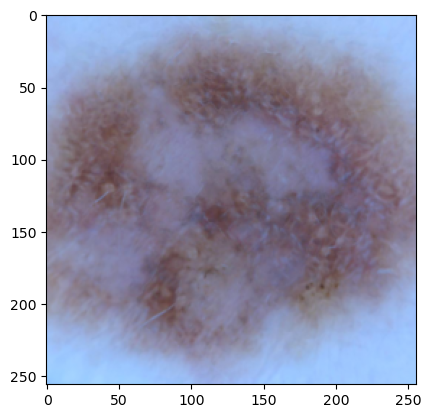

In [39]:
plt.imshow(np.transpose(sample['image'], (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


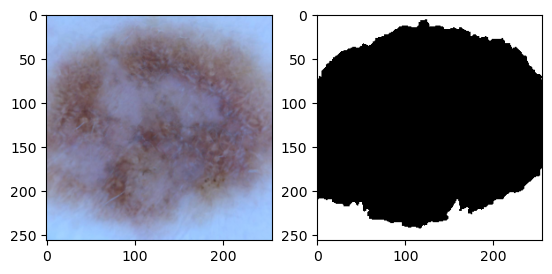

In [40]:
flip_transform = RandomFlip(probability = 0.5)
flipped_image = flip_transform.__call__(sample)

fig, ax = plt.subplots(1,2)
ax[0].imshow(np.transpose(flipped_image['image'], (1, 2, 0)))
ax[1].imshow(np.transpose(flipped_image['label'], (1, 2, 0)), cmap = 'Greys')



In [41]:
class RandomAffine(object):
    """
    Create random affine transformation including rotation, translation, shears and zooms
    """
    def __init__(self, prob_trans=0, prob_rot=0, prob_zoom=0, prob_shear=0, trans=2, rot=45, zoom=2, shear=45.0):
        self.prob_trans = prob_trans
        self.prob_rot = prob_rot 
        self.prob_zoom = prob_zoom 
        self.prob_shear = prob_shear 
        self.trans = trans
        self.rot = rot
        self.zoom = zoom
        self.shear = shear
        self.random_trans = random.random()
        self.random_rot = random.random()
        self.random_zoom = random.random()
        self.random_shear = random.random()

    def create_affine(self):
        # Translation:
        if self.random_trans < self.prob_trans:
            translation = Affine.translation(self.trans, self.trans)
        else:
            translation = Affine.identity()
 
        # Rotation:
        if self.random_rot < self.prob_rot:
            rotation = Affine.rotation(self.rot)
        else:
            rotation = Affine.identity()

        # Scale
        if self.random_zoom < self.prob_zoom:
            zoom_t = Affine.scale(self.zoom)
        else:
            zoom_t = Affine.identity()

        # Shear
        if self.random_shear < self.prob_shear:
            shear_t = Affine.shear(self.shear, self.shear)
        else:
            shear_t = Affine.identity()

        # Create affine transformation
        affine = translation*rotation*zoom_t*shear_t
         
        return affine

    def create_offset(self, trans_y, trans_x):
        # Translation:
        offset = Affine.translation(trans_y, trans_x)
 
        offset_matrix = np.reshape(np.array(offset), [3,3])
        true_offset = np.linalg.inv(offset_matrix)
    
        return offset_matrix, true_offset

    def __call__(self, sample):
        
        image_array = np.array(sample['image'])  #.numpy()  C X H X W
        label_array = np.squeeze(np.array(sample['label'])) #.numpy()


        height = image_array.shape[1]
        width = image_array.shape[2]
        centre_y = (height-1)/2
        centre_x = (width-1)/2

        colours_R = image_array[0, :, :]
        colours_G = image_array[1, :, :]
        colours_B = image_array[2, :, :]
       
        # Create affine matrix and inverse matrix for 'pull' resampling
        affine = self.create_affine()
        new_affine = np.reshape(np.array(affine), [3,3])
        true_affine = np.linalg.inv(new_affine)

        # create an offset to rotate around centre of image
        offset_affine = self.create_offset(trans_y = -centre_y, trans_x = -centre_x)
        true_offset = offset_affine[1]
        offset_matrix = offset_affine[0]

        # Create afffine matrix with respect to the centre of the image
        total_affine = true_offset @ true_affine @ offset_matrix

        # Transform each RGB component and label
        transformed_R = sp.ndimage.affine_transform(colours_R, total_affine)
        transformed_G = sp.ndimage.affine_transform(colours_G, total_affine)
        transformed_B = sp.ndimage.affine_transform(colours_B, total_affine)
        transformed_label = sp.ndimage.affine_transform(label_array, total_affine)
        
        # Stack RGB components
        transformed_image = np.dstack((transformed_R, transformed_G, transformed_B))       
                
        ## convert image back to torch tensor!!!! transpose!!

        new_image = torch.from_numpy(np.transpose(transformed_image, (2,0,1))).float()
        new_label = torch.from_numpy(np.expand_dims(transformed_label,0)).long()
        
        #return transformed_image, transformed_label

        return {'image':new_image, 'label':new_label}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


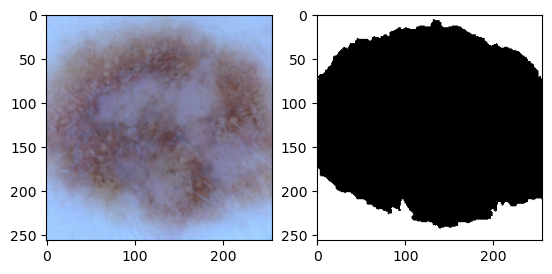

In [42]:
# Visualise the effects of random flips

flip_transform = RandomFlip(probability = 1)
flipped_image = flip_transform.__call__(sample)
fig1, ax1 = plt.subplots(1,2)
ax1[0].imshow(np.transpose(flipped_image['image'], (1, 2, 0)))
ax1[1].imshow(np.transpose(flipped_image['label'], (1, 2, 0)), cmap = 'Greys')

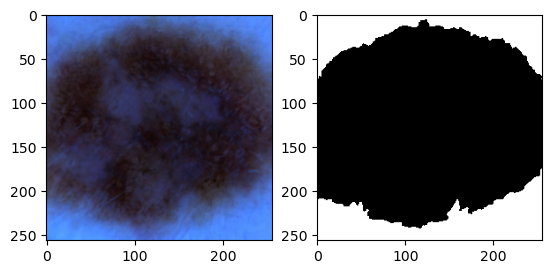

In [43]:
# Visualise the effects of random gamma

gamma_transform = RandomGamma(probability = 1, gamma_max = 4)
gamma_image = gamma_transform.__call__(sample)

fig2, ax2 = plt.subplots(1,2)
ax2[0].imshow(np.transpose(gamma_image['image'], (1, 2, 0)))
ax2[1].imshow(np.transpose(gamma_image['label'], (1, 2, 0)), cmap = 'Greys')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


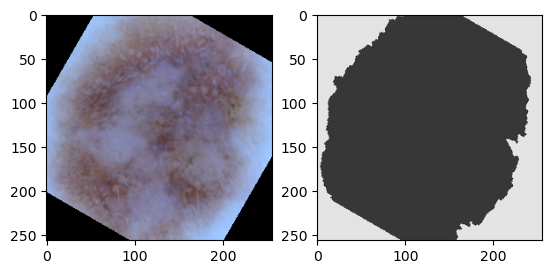

In [44]:
# Visualise the effects of random rotation

test_rotation =  RandomAffine(prob_rot = 1, rot = 60)
rotated_image = test_rotation.__call__(sample)

fig3, ax3 = plt.subplots(1,2)
ax3[0].imshow(np.transpose(rotated_image['image'], (1, 2, 0)))
ax3[1].imshow(np.transpose(rotated_image['label'], (1, 2, 0)), cmap = 'Greys')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


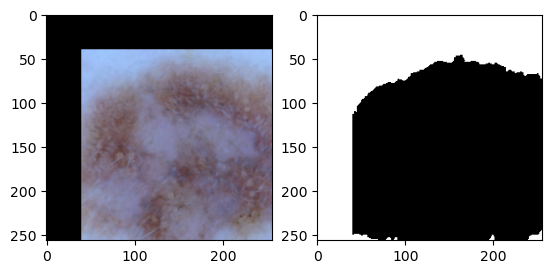

In [45]:
# Visualise the effects of random translation

test_translation =  RandomAffine(prob_trans = 1, trans = 40)
translated_image = test_translation.__call__(sample)

fig4, ax4 = plt.subplots(1,2)
ax4[0].imshow(np.transpose(translated_image['image'], (1, 2, 0)))
ax4[1].imshow(np.transpose(translated_image['label'], (1, 2, 0)), cmap = 'Greys')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


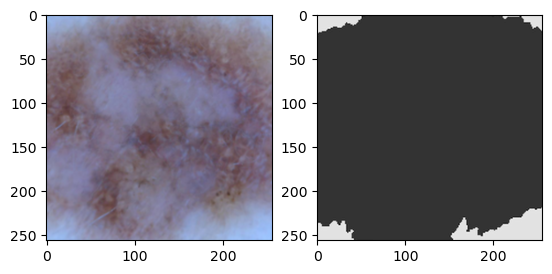

In [46]:
# Visualise the effects of random zoom

test_zoom =  RandomAffine(prob_zoom = 1, zoom = 1.25)
zoomed_image = test_zoom.__call__(sample)

fig5, ax5 = plt.subplots(1,2)
ax5[0].imshow(np.transpose(zoomed_image['image'], (1, 2, 0)))
ax5[1].imshow(np.transpose(zoomed_image['label'], (1, 2, 0)), cmap = 'Greys')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


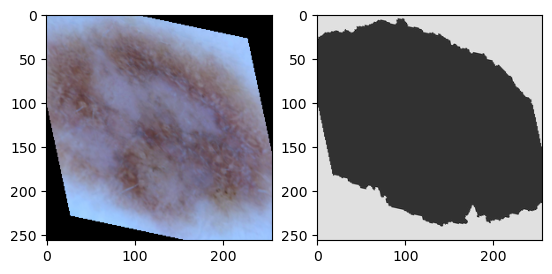

In [47]:
# Visualise the effects of random shear

test_shear =  RandomAffine(prob_shear = 1, shear = 12)
sheared_image = test_shear.__call__(sample)

fig6, ax6 = plt.subplots(1,2)
ax6[0].imshow(np.transpose(sheared_image['image'], (1, 2, 0)))
ax6[1].imshow(np.transpose(sheared_image['label'], (1, 2, 0)), cmap = 'Greys')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


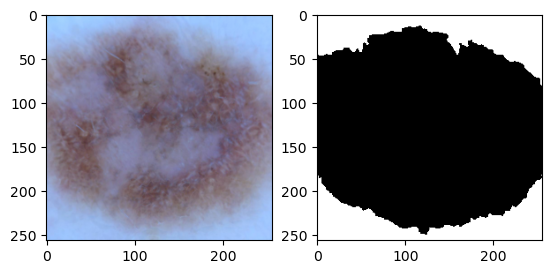

In [48]:
# Visualise augmentation examples according to the following probability (flip 0.5, rotation: 0.4, translation: 0.3, zoom: 0.1, shear 0.1)

augment_flip = RandomFlip(probability = 0.5)
flipped_sample = augment_flip.__call__(sample)
augmentation = RandomAffine(prob_trans = 0.3, prob_rot = 0.4, prob_zoom = 0.1, prob_shear = 0.1)
augmented_flip = augmentation.__call__(flipped_sample)

fig7, ax7 = plt.subplots(1,2)
ax7[0].imshow(np.transpose(augmented_flip['image'], (1, 2, 0)))
ax7[1].imshow(np.transpose(augmented_flip['label'], (1, 2, 0)), cmap = 'Greys')

In [69]:
# Get input and output shapes for my model
input_shape = augmented_flip['image'].shape
output_shape = augmented_flip['label'].shape

print('Input shape: ' + str(input_shape))
print('Output shape: ' + str(output_shape))

Input shape: torch.Size([3, 256, 256])
Output shape: torch.Size([1, 256, 256])


## Exercise 1 - Part 3 -  Model training and comparisons on a small labelled dataset / 10pts

In a first stage, you will need to instantiate a network. We suggest deeplabv3_resnet50 that you will need to modify to be applicable for binary segmentation - think about the dimensions in your output layer and the subsequent operations you will need to perform

In [88]:
# Suggestion for weights initialisation when starting from scratch
def initialize_weights(*models):
    for model in models:
        for module in model.modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight)
                if module.bias is not None:
                    module.bias.data.zero_()
            elif isinstance(module, nn.BatchNorm2d):
                module.weight.data.fill_(1)
                module.bias.data.zero_()

a) Define your model to be trained from scratch adapting the deeplabv3 network from pytorch /1pt

In [130]:
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights

scratch_weights = initialize_weights()

model_scratch = deeplabv3_resnet50(weights = scratch_weights, weights_backbone = None)


# Print model head to evaluate classifier (21 classes)
print('Original: ' + str(model_scratch.classifier[4]))

# Change the number of classes in the classifier to 1 for binary segmentation
num_classes = 1
model_scratch.classifier[4] = nn.Conv2d(
                            in_channels = 256,
                            out_channels = num_classes,
                            kernel_size = (1,1),
                            stride = (1,1)
                            )

print('Replaced: ' + str(model_scratch.classifier[4]))

print(model_scratch)


Original: Conv2d(256, 21, kernel_size=(1, 1), stride=(1, 1))
Replaced: Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, ep

In [129]:
print(scratch_weights)

None


b) Define a model with pretrained weights from natural images, adapt it to your binary segmentation case, and make only the parameters from the classifier as trainable /2pt


In [139]:
# For a pretrained network, we suggest you first download the weights separately and then load them manually before modifying your network.
# this is useful if the automated download does not work for you

pretrained_weights = DeepLabV3_ResNet50_Weights.DEFAULT
pretrained_model = deeplabv3_resnet50(weights = pretrained_weights, weights_backbone = None)

pretrained_model.classifier[4] = nn.Conv2d(
                            in_channels = 256,
                            out_channels = num_classes,
                            kernel_size = (1,1),
                            stride = (1,1)
                            )



In [140]:
# Loss function to be used 

def soft_dice_loss(output, target):
    s = (10e-20)
    output = output.type(torch.FloatTensor)
    target = target.type(torch.FloatTensor)
    intersect = torch.sum(output * target )
    dice = (2 * intersect + s) / (torch.sum(output) + torch.sum(
        target)+s )
    return 1 - dice

c) Define your training process using 50 epochs, an Adam optimizer with learning rate of 0.0001 and batch size of 20 /4pts

In [105]:
number_of_epochs = 50
model_full = pretrained_model
BATCH_SIZE = 20
dataloader = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle = True)

#for sample in dataloader:
   # print(d['image'])


for sample in dataloader:
# Get a batch of source slices
# Get a batch of target slices
    batch_images = sample['image']
    batch_labels = sample['label']
    output = model_scratch(batch_images)
            #loss = soft_dice_loss(output, batch_labels)




100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:05<00:00, 73.17s/it]


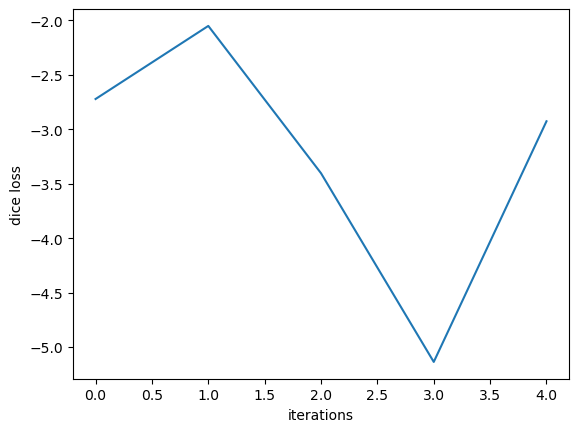

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:47<00:00, 81.51s/it]


<Figure size 640x480 with 0 Axes>

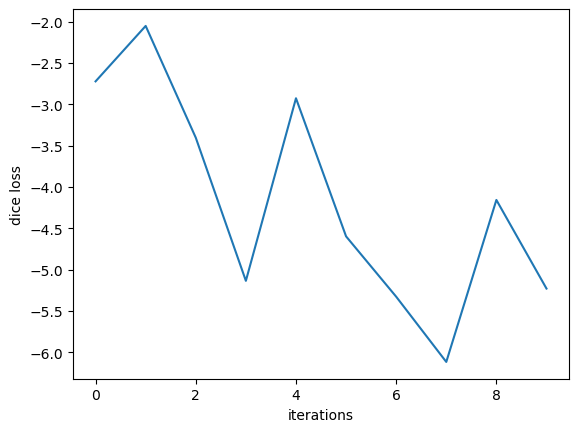

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:58<00:00, 71.66s/it]


<Figure size 640x480 with 0 Axes>

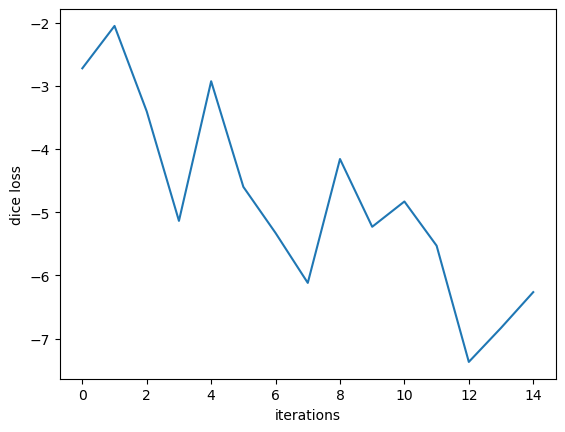

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:15<00:00, 75.10s/it]


<Figure size 640x480 with 0 Axes>

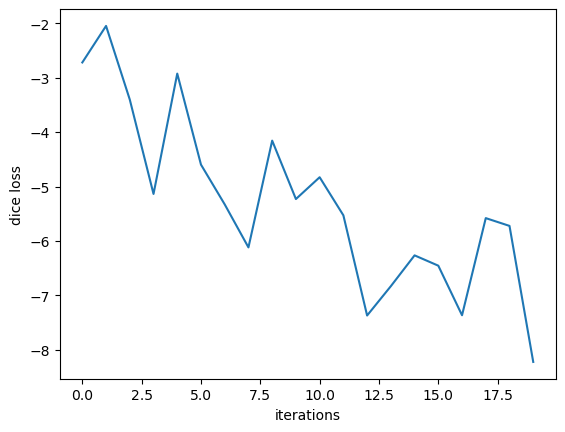

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:57<00:00, 71.50s/it]


<Figure size 640x480 with 0 Axes>

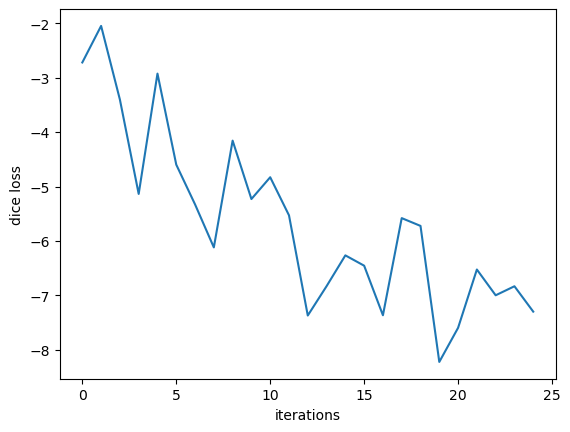

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:55<00:00, 71.01s/it]


<Figure size 640x480 with 0 Axes>

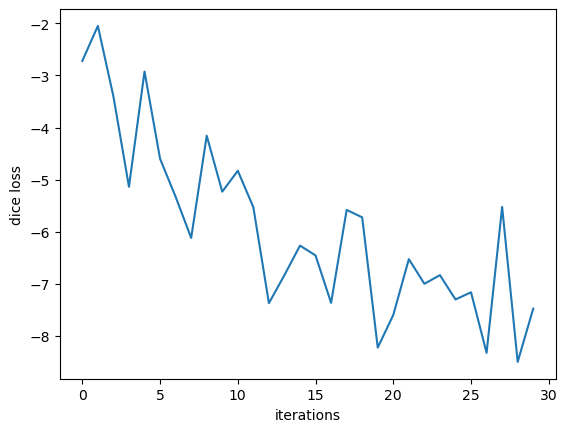

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:51<00:00, 70.30s/it]


<Figure size 640x480 with 0 Axes>

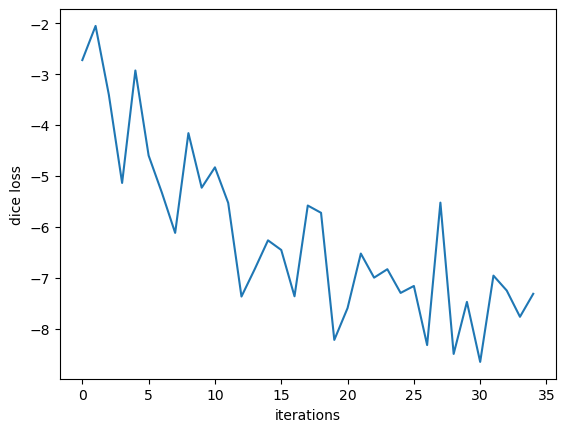

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:37<00:00, 67.56s/it]


<Figure size 640x480 with 0 Axes>

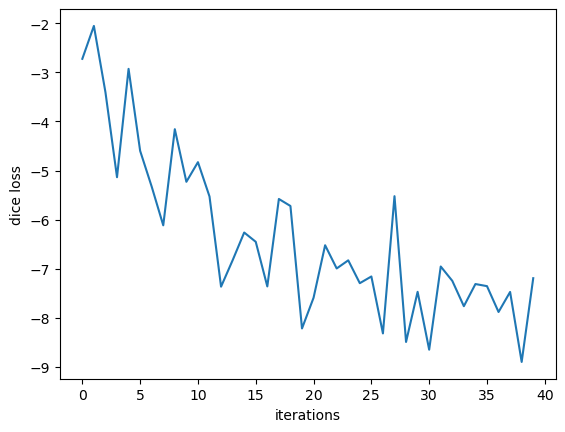

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:45<00:00, 69.07s/it]


<Figure size 640x480 with 0 Axes>

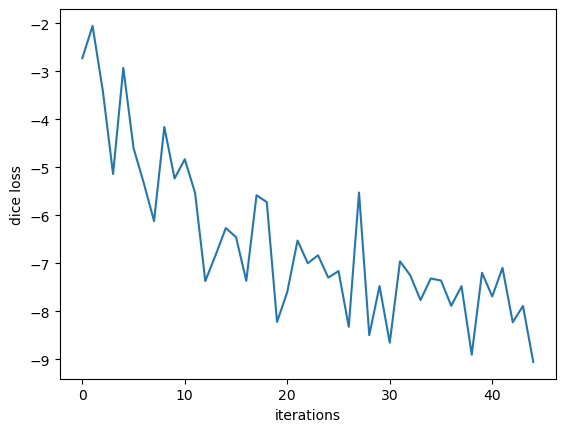

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:50<00:00, 70.14s/it]


<Figure size 640x480 with 0 Axes>

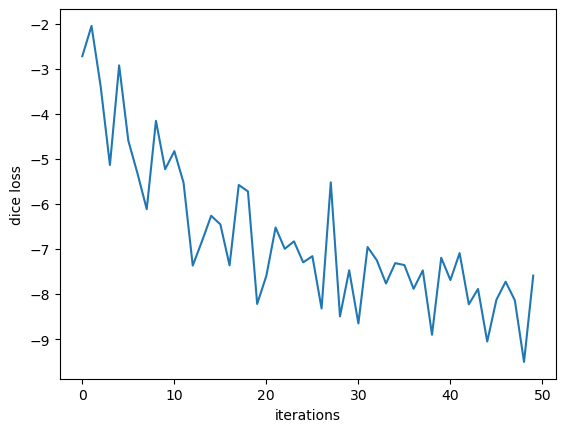

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:43<00:00, 68.63s/it]


<Figure size 640x480 with 0 Axes>

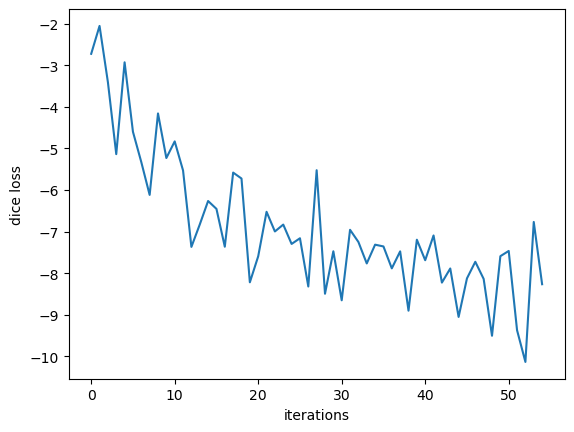

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:37<00:00, 67.42s/it]


<Figure size 640x480 with 0 Axes>

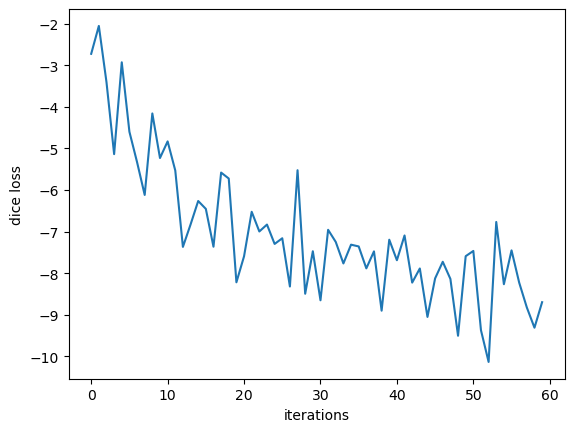

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:35<00:00, 67.16s/it]


<Figure size 640x480 with 0 Axes>

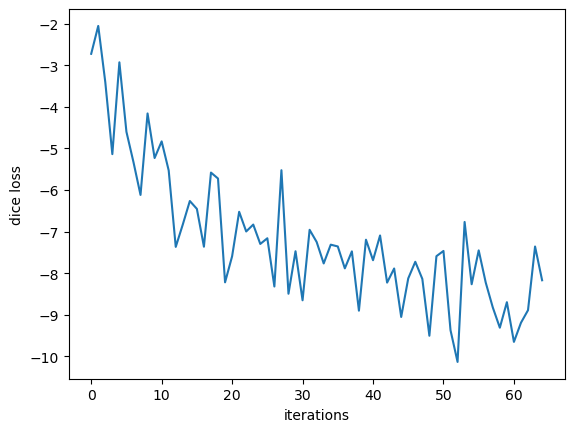

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:46<00:00, 69.33s/it]


<Figure size 640x480 with 0 Axes>

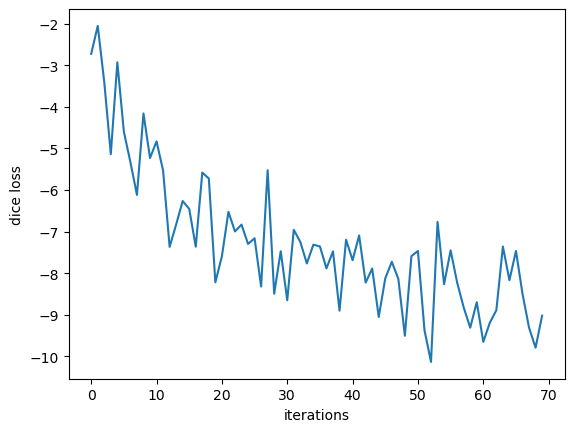

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:48<00:00, 69.62s/it]


<Figure size 640x480 with 0 Axes>

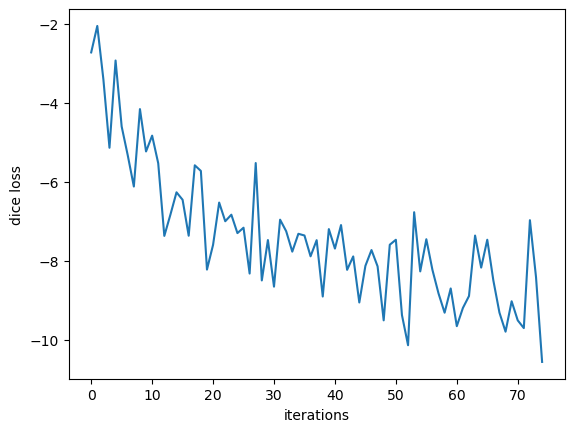

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:39<00:00, 67.97s/it]


<Figure size 640x480 with 0 Axes>

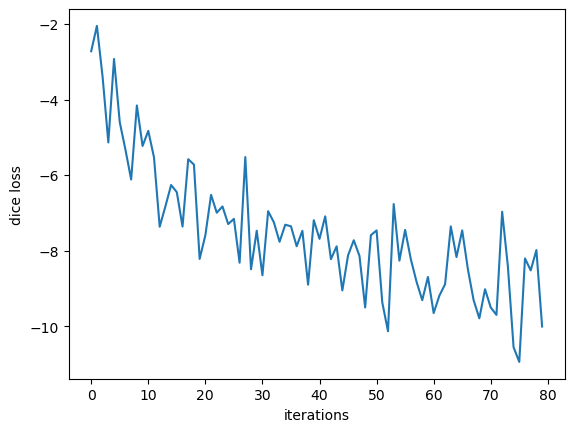

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:34<00:00, 66.99s/it]


<Figure size 640x480 with 0 Axes>

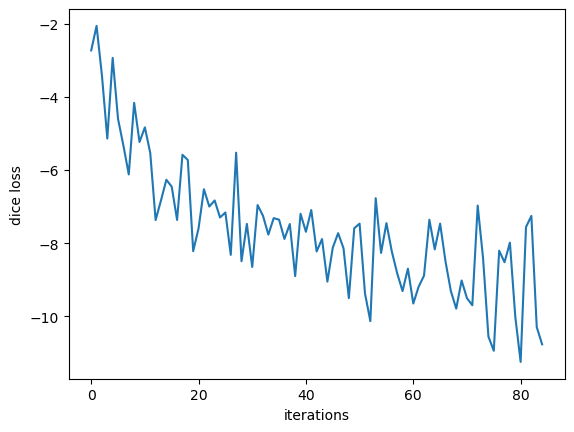

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:39<00:00, 67.94s/it]


<Figure size 640x480 with 0 Axes>

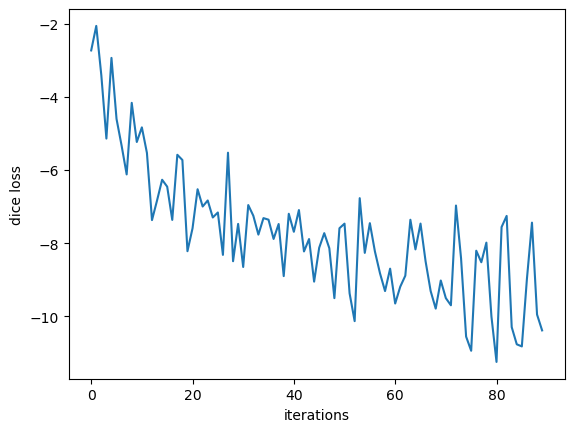

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:47<00:00, 69.59s/it]


<Figure size 640x480 with 0 Axes>

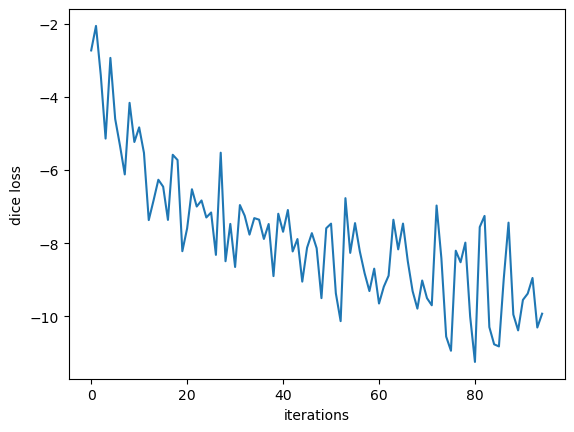

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:44<00:00, 68.96s/it]


<Figure size 640x480 with 0 Axes>

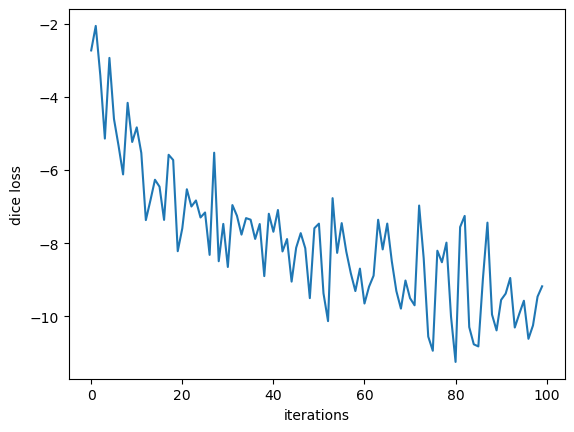

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:40<00:00, 68.01s/it]


<Figure size 640x480 with 0 Axes>

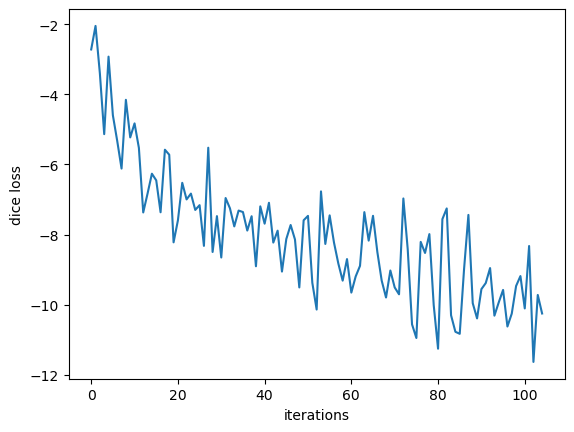

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:11<00:00, 74.33s/it]


<Figure size 640x480 with 0 Axes>

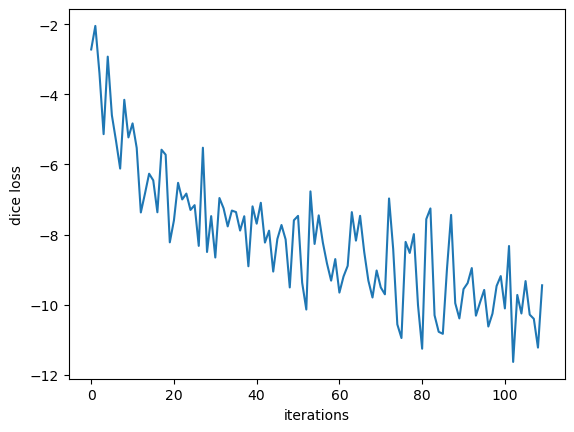

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:18<00:00, 75.62s/it]


<Figure size 640x480 with 0 Axes>

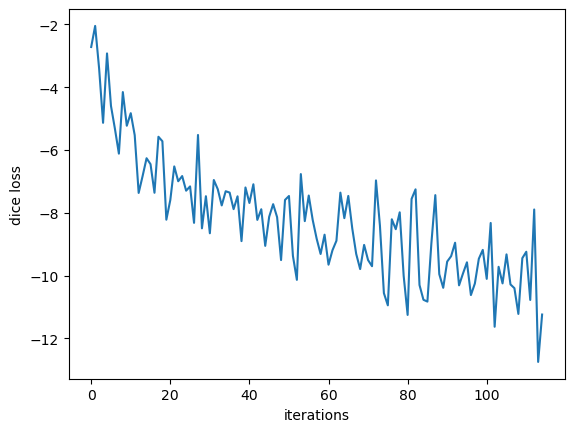

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:49<00:00, 81.81s/it]


<Figure size 640x480 with 0 Axes>

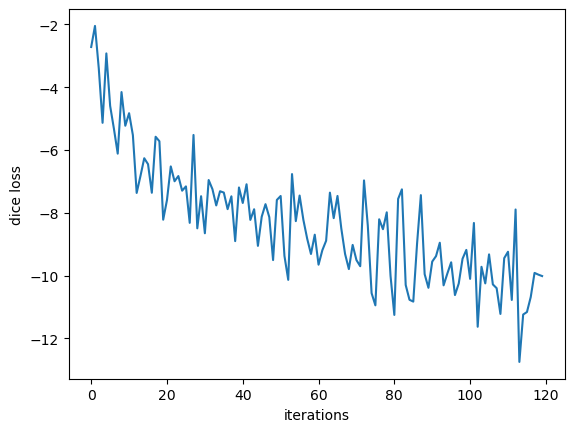

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:43<00:00, 68.74s/it]


<Figure size 640x480 with 0 Axes>

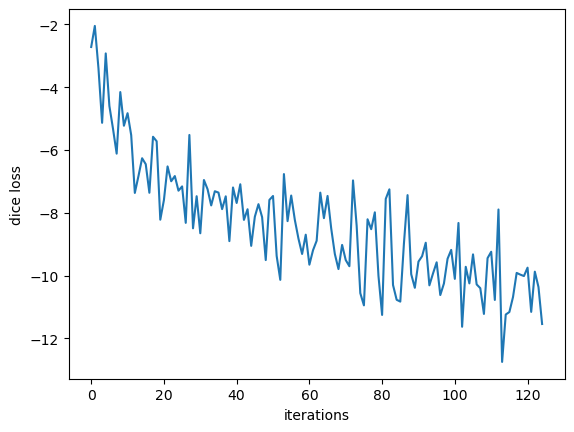

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:44<00:00, 68.90s/it]


<Figure size 640x480 with 0 Axes>

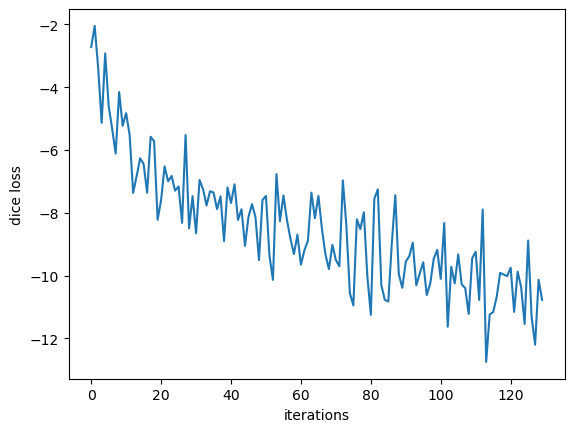

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:47<00:00, 69.52s/it]


<Figure size 640x480 with 0 Axes>

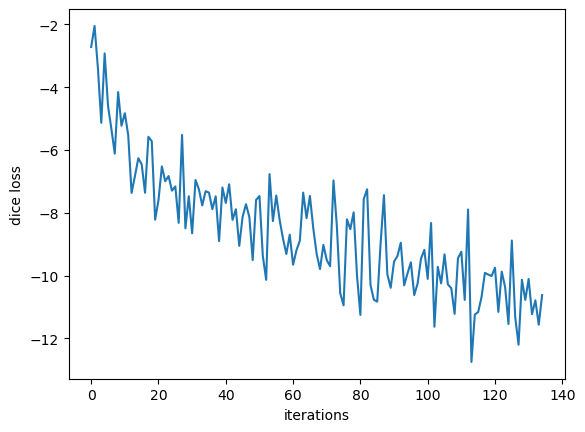

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:52<00:00, 70.45s/it]


<Figure size 640x480 with 0 Axes>

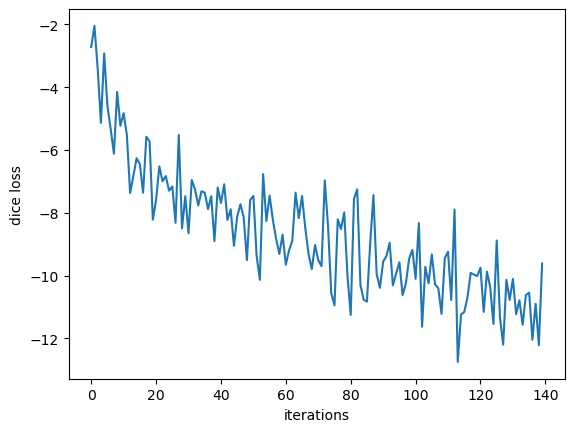

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:49<00:00, 69.83s/it]


<Figure size 640x480 with 0 Axes>

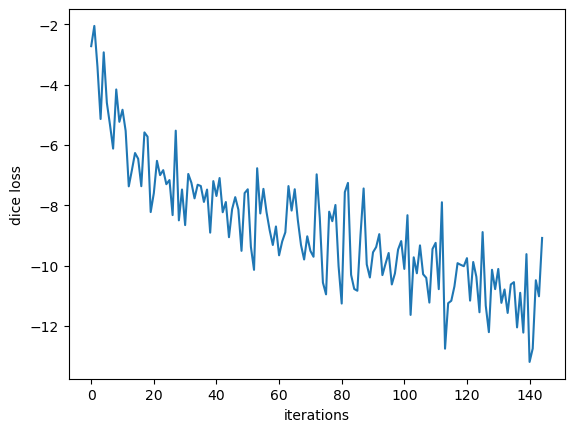

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:53<00:00, 70.78s/it]


<Figure size 640x480 with 0 Axes>

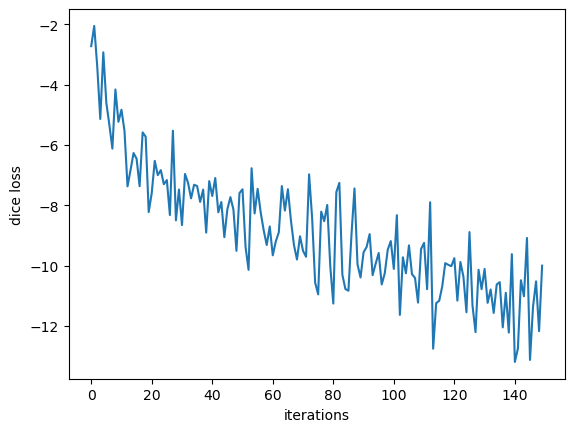

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:51<00:00, 70.25s/it]


<Figure size 640x480 with 0 Axes>

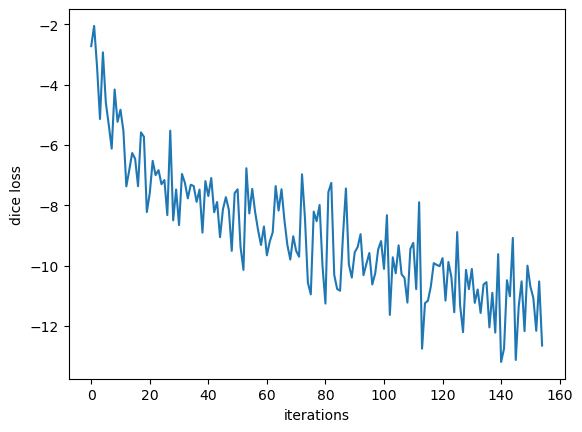

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:42<00:00, 68.51s/it]


<Figure size 640x480 with 0 Axes>

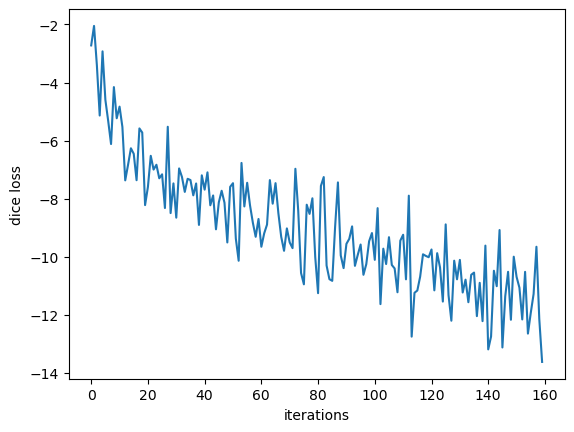

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:08<00:00, 73.77s/it]


<Figure size 640x480 with 0 Axes>

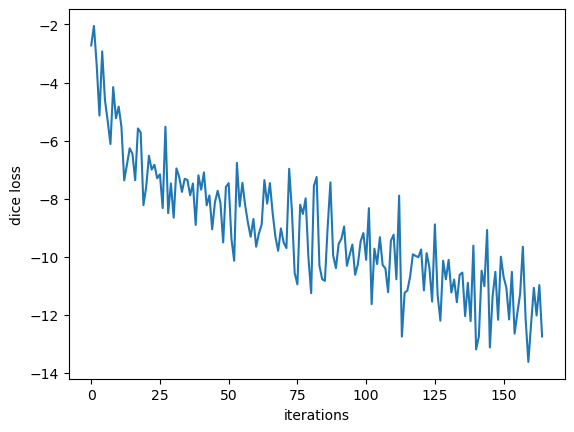

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [07:48<00:00, 93.73s/it]


<Figure size 640x480 with 0 Axes>

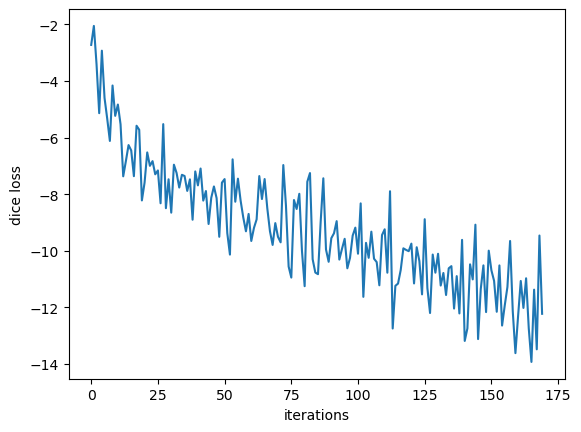

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [08:15<00:00, 99.10s/it]


<Figure size 640x480 with 0 Axes>

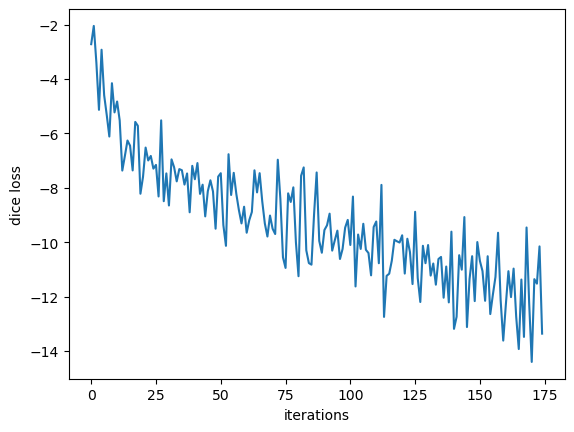

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:24<00:00, 76.90s/it]


<Figure size 640x480 with 0 Axes>

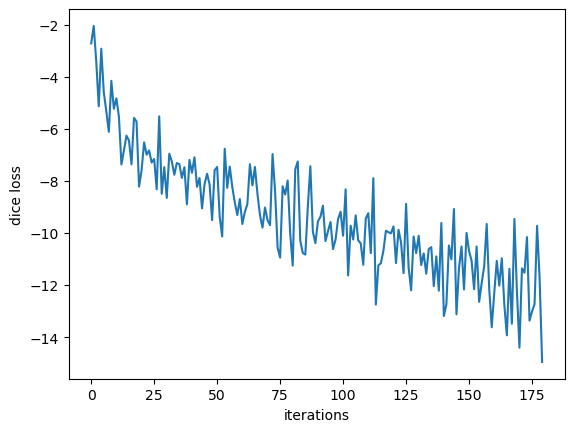

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:45<00:00, 81.13s/it]


<Figure size 640x480 with 0 Axes>

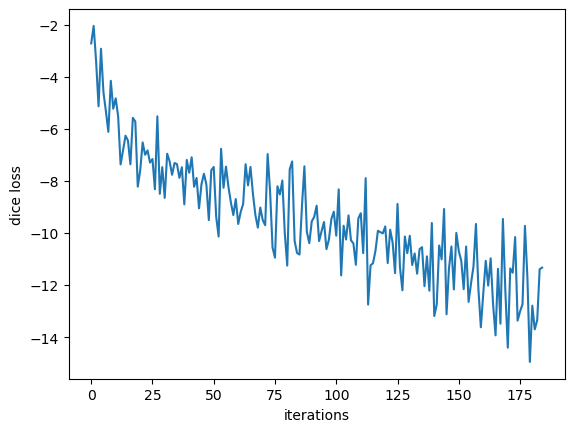

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:55<00:00, 83.04s/it]


<Figure size 640x480 with 0 Axes>

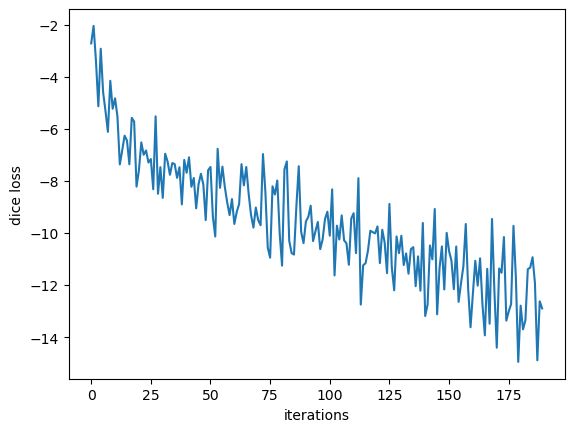

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:49<00:00, 69.87s/it]


<Figure size 640x480 with 0 Axes>

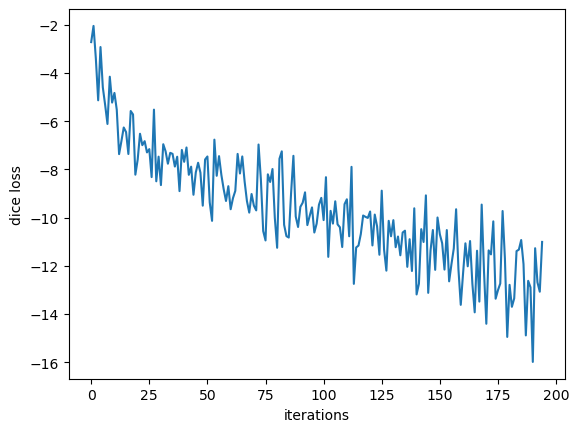

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:50<00:00, 70.02s/it]


<Figure size 640x480 with 0 Axes>

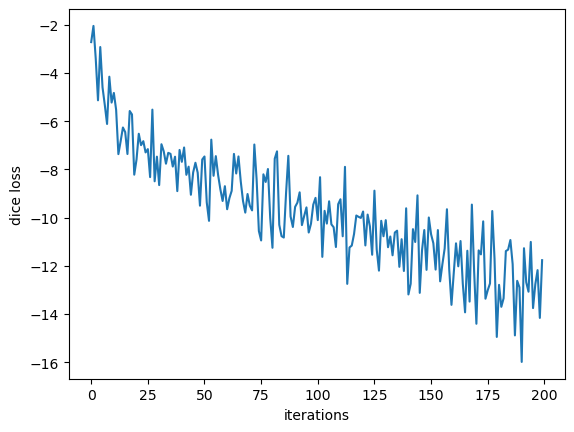

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:44<00:00, 68.87s/it]


<Figure size 640x480 with 0 Axes>

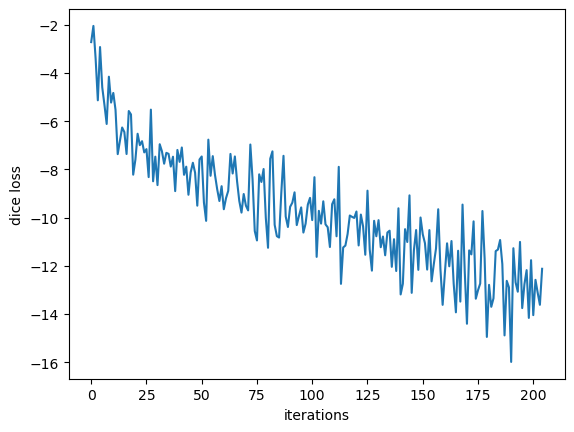

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:19<00:00, 75.83s/it]


<Figure size 640x480 with 0 Axes>

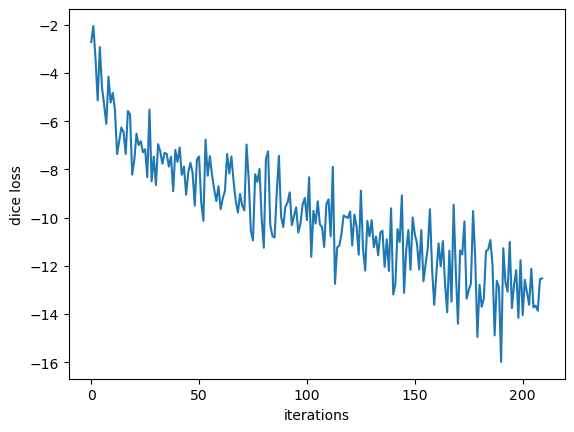

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [07:17<00:00, 87.40s/it]


<Figure size 640x480 with 0 Axes>

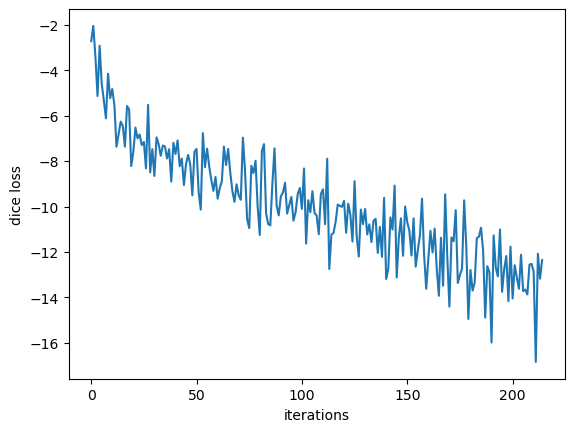

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [07:47<00:00, 93.60s/it]


<Figure size 640x480 with 0 Axes>

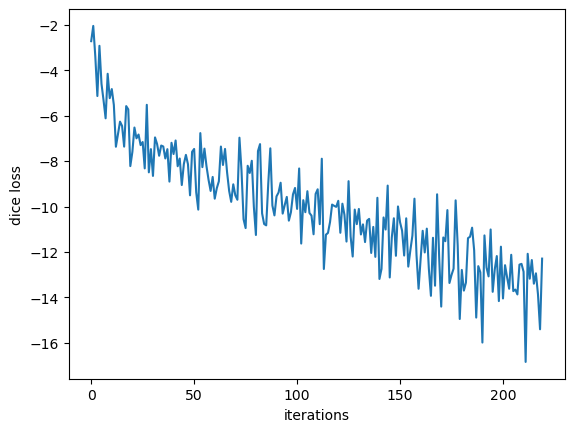

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [07:51<00:00, 94.25s/it]


<Figure size 640x480 with 0 Axes>

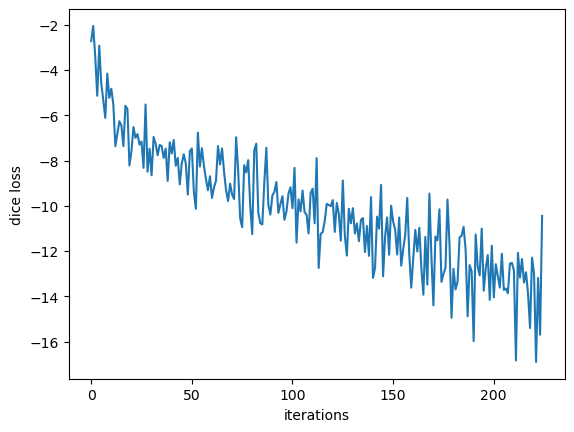

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [07:09<00:00, 85.93s/it]


<Figure size 640x480 with 0 Axes>

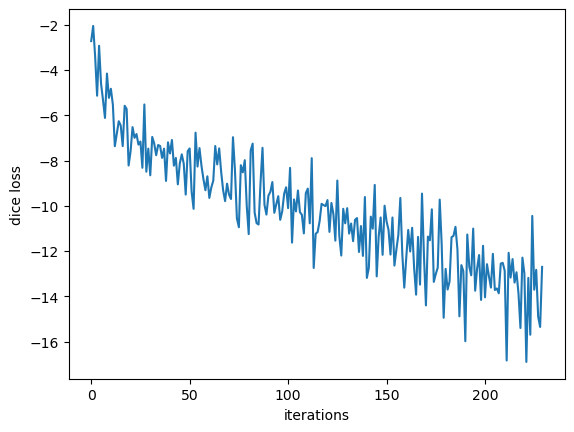

 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [06:05<01:33, 93.44s/it]tensor(-14.6258, grad_fn=<RsubBackward1>)


In [ ]:
number_of_epochs = 50
model_full = model_scratch
BATCH_SIZE = 20
optimizer_backbone = torch.optim.Adam(params = model_scratch.parameters(), lr = 0.0001)
path = 'Training Results'

dataloader = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle = True)


list_loss = []
for epoch in range(number_of_epochs):
    model_full.train()
    if epoch % 1 == 0 and epoch > 0:
        name = path + 'SegISICDLV_%d.pt' %epoch
        torch.save(model_full.state_dict(),name)
        fig, ax = plt.subplots(1,1)
        ax.plot(np.array(list_loss))
        ax.set_xlabel('iterations')
        ax.set_ylabel('dice loss')
        plt.show()
        plt.savefig('TrainingLoss.png')
    with tqdm(total=len(dataloader), file=sys.stdout) as pbar:
        start_time = time.time()
        running_loss = 0
        indb = 0
        for sample in dataloader:
            # Get a batch of source slices
            # Get a batch of target slices
            batch_images = sample['image']
            batch_labels = sample['label']
            output = model_scratch(batch_images)
            loss = soft_dice_loss(output['out'], batch_labels)
            
            total_loss = loss
            print( total_loss)
            # total_loss.requires_grad = True
            model_full.zero_grad()
            total_loss.backward()
            optimizer_backbone.step()
            optimizer_backbone.zero_grad()
            # print(model_full.rpn_head.rpn_conv.weight[0])
            running_loss += total_loss.item()
            list_loss.append(total_loss.item())
            indb += 1
            pbar.update(1)


        end_time = time.time()



d) Train the following models: /3pts
- from scratch
- from scratch with augmentation
- starting from pretrained state over natural images
- starting from pretrained state over natural images and with augmentation

## Exercise 1 -  Part 4 - Evaluation of performance /10 pts
Using the dice-sorensen coefficient defined as $\frac{2 x TP}{2 x TP + FP + FN}$ for each image of the test set, compare the performance on the test set for 

a) Implement the dice coefficients for each image given your batch prediction and your batch target /2pts

In [ ]:
def dice_value(batch_pred, batch_target):
    
    #TOFILL
    
    return dice_values



In [ ]:
# First define your dataloader
transform_test = transforms.Compose([ToTensor(),CenterCrop((1000,1000)), Rescale((256,256))])
test_dataset = ISICDataset(image_path='TOFILL',
                                           label_path='TOFILL',
                                           transform=transform_test)
test_dataloader = DataLoader(test_dataset, batch_size=20,
                        shuffle=False, num_workers=0)


b) Load the models you want to evaluate or use the latest you have been training and set to evaluation /2pts


In [ ]:
# TOFILL

c) Go through the samples of your dataloader and extract the dice values for each image /3pts


In [ ]:
# TO FILL

d) Aggregate the results for each model and compare the performance /3pts

In [ ]:
# TO FILL

## Exercise 1 -  Part 5 - Weak supervision - /20 pts
Final task - Using the pseudo-labeling framework, make use of the unlabeled data and compare performance with your previous models

In [ ]:
# TO DO

# Exercise 2 - Hippocampal volume and Disease progression in ADNI3 / 35pts
This component of the coursework will consider tabular data from the ADNI dataset - you can find the relevant files [here](https://liveuclac.sharepoint.com/:f:/s/MPHY0050/Evad44eCZ4lDp54mCaJKEZkBvOO90Di89tCQtFFBDVLz7Q?e=lnkU4X)

In [ ]:
# In the following, we will only consider data from the ADNI3 wave

data = pd.read_csv('ADNIMERGE.csv')
data_adni3 = data[data['COLPROT']=='ADNI3']

## Exercise 2 - Part 1 - Longitudinal evolution of Hippocampal volume

a) Consider all the subjects with 3 or more data points for hippocampal volumes and display the evolution over time for 3 subjects of each APOE4 category (APOE4=0, APOE4=1 and APOE4=2) /5pts

b) Using the full case data, build and compare the 4 following linear mixed effects models for the evaluation longitudinal Hippocampal volumes across the differet APOE groups adjusting for age at first available assessment, ICV and sex:
- using only random intercept or considering both random slope and random intercept
- considering the same or different slopes across APOE4 groups

Use the BIC criterion to compare the models and identify the one that seems to fit best. The Bayesian Information Criterion is defined as -2 * log-likelihood + log(number_observations) * number of degrees of freedom

(Hint: using the powell method of optimisation may help with convergence of your models) 

Does the data support that APOE influences the rate of HV decline? State your evidence /7pts

c) Revisit question b, this time considering different strategies of data imputation to tackle the missing data. Discuss on the impact on your models /5pts

## Exercise 2 - Part 2 - Disease progression modelling

a) Using the methods you have seen for the DPM lecture, adapt the code to combine the data from the file with FreeSurfer outputs for ADNI3 /3pts

b) Build your z-scores considering as controls the individuals classified as control at the first available timepoint in the ADNI3 dataset and AB negatives. Adjust for ICV and sex and age /5pts

c) In your sustain model, include the volume of the following structures: frontal, parietal, temporal, occipital, hippocampus, insula and thalamus. Describe briefly your results and the appropriate number of subtypes and what their main characteristics are / 5pts

d) Using the subjects with at least two timepoints available and classified as AB positive at some point, find for these individuals their predicted stage and subtype at the first timepoint and last timepoint. Comment on consistencies and differences across diagnosis groups. / 5pts